In [1]:
import os
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
directory_in_str = "/home/chingyuenliu/TTIC31160_bioinfo/hw1/pairwise_data/pairwise_seq/"

In [4]:
ground_path_dir = '/home/chingyuenliu/TTIC31160_bioinfo/hw1/pairwise_data/pairwise_align/'

In [5]:
def check_char(char0,char1):
    #check if two character are the same
    return char0.lower() == char1.lower()

In [16]:
def mkmtx(seq0,seq1,local=False,match =4,mmatch=-3,gap=-5,gap_ext=-1):
    #make dynamic programming matrix
    
    mtx = np.zeros([3,len(seq0)+1,len(seq1)+1])
    _,d1,d2=mtx.shape

    if not local:
        #Global alignment, the value could be negative.
        for i in range(1,d1):
            mtx[:,i,0]=(gap+gap_ext*(i))*np.ones(3)
        for i in range(1,d2):
            mtx[:,0,i]=(gap+gap_ext*(i))*np.ones(3)
        
        #the first layer is match/mismatch, second layer is gap on first 
        #sequence, third layer is gap on second sequence.
        for i in range(1,d1):
            for j in range(1,d2):
                if check_char(seq0[i-1],seq1[j-1]):
                    score = match
                else:
                    score =mmatch
                mtx[0,i,j] = np.max(mtx[:,i-1,j-1]) + score
                mtx[1,i,j] = np.max([mtx[0,i,j-1]+gap+gap_ext,mtx[1,i,j-1]+
                                     gap_ext,mtx[2,i,j-1]+gap+gap_ext])
                mtx[2,i,j] = np.max([mtx[0,i-1,j]+gap+gap_ext,mtx[1,i-1,j]+
                                     gap+gap_ext,mtx[2,i-1,j]+gap_ext])
    else:
        #local alignment, the value is non-negative
        for i in range(1,d1):
            for j in range(1,d2):
                if check_char(seq0[i-1],seq1[j-1]):
                    score = match
                else:
                    score =mmatch
                mtx[0,i,j] = max(np.max(mtx[:,i-1,j-1]) + score, 0)
                mtx[1,i,j] = np.max([mtx[0,i,j-1]+gap+gap_ext,mtx[1,i,j-1]+
                                     gap_ext,mtx[2,i,j-1]+gap+gap_ext,0])
                mtx[2,i,j] = np.max([mtx[0,i-1,j]+gap+gap_ext,mtx[1,i-1,j]+
                                     gap+gap_ext,mtx[2,i-1,j]+gap_ext,0])
    return mtx

In [7]:
def back_tracing(seq0,seq1,mtx,local=False):

    #idx = 0, match/mismatch
    #idx = 1, gap on seq0, letter on seq1
    #idx = 2, letter on seq0, gap on seq1

    if not local:
        #back tracing for global alignment
        _,d1,d2=mtx.shape
        seq0_aln=[]
        seq1_aln=[]
        i=d1-1
        j=d2-1
        while(i != 0 and j != 0):
            idx = np.argmax(mtx[:,i,j])
            if idx ==0:
                seq0_aln.append(seq0[i-1])
                seq1_aln.append(seq1[j-1])
                i -= 1
                j -= 1
            elif idx ==1:
                seq0_aln.append('-')
                seq1_aln.append(seq1[j-1])
                j -= 1
            elif idx ==2:
                seq0_aln.append(seq0[i-1])
                seq1_aln.append('-')
                i -= 1

    else:
        #back tracing for local alignment
        _,d1,d2=mtx.shape
        _,i,j=np.unravel_index(np.argmax(mtx),mtx.shape)

        seq0_aln=[]
        seq1_aln=[]

        for chara in seq0[i:][::-1]:
            seq0_aln.append(chara)
        for i1 in range(d1-1,i,-1):
            seq1_aln.append('-')

        for chara in seq1[j:][::-1]:
            seq1_aln.append(chara)
        for i1 in range(d2-1,j,-1):
            seq0_aln.append('-')
            
        while(i != 0 and j != 0):
            if np.max(mtx[:,i,j]) ==0:
                break
            idx = np.argmax(mtx[:,i,j])
            if idx ==0:
                seq0_aln.append(seq0[i-1])
                seq1_aln.append(seq1[j-1])
                i -= 1
                j -= 1
            elif idx ==1:
                seq0_aln.append('-')
                seq1_aln.append(seq1[j-1])
                j -= 1
            elif idx ==2:
                seq0_aln.append(seq0[i-1])
                seq1_aln.append('-')
                i -= 1
        
        
        for chara in seq0[:i][::-1]:
            seq0_aln.append(chara)
        for i1 in range(i):
            seq1_aln.append('-')
        for chara in seq1[:j][::-1]:
            seq1_aln.append(chara)
        for i1 in range(j):
            seq0_aln.append('-')  
    return ''.join(reversed(seq0_aln)), ''.join(reversed(seq1_aln))

In [8]:
def seq_idx(seq):
    #change the letter sequence to index sequence
    seq_lst = []
    counter = 0
    for i in seq:
        if i.isalpha():
            seq_lst.append(counter)
            counter +=1
        else:
            seq_lst.append(-1)
    return seq_lst

In [9]:
def accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al):
    #calcualte recall and precision
    seq1_gt_lst = seq_idx(seq1_gt)
    seq0_gt_lst = seq_idx(seq0_gt)
    seq0_al_lst = seq_idx(seq0_al)
    seq1_al_lst = seq_idx(seq1_al)
    
    gt_aln_idx = list(zip(seq0_gt_lst,seq1_gt_lst))
    al_aln_idx = list(zip(seq0_al_lst,seq1_al_lst))
    
    #get rid off the entry that aligned with gap
    gt_aln_idx = [x for x in gt_aln_idx if not -1 in x]
    al_aln_idx = [x for x in al_aln_idx if not -1 in x]
    
    #count how many alignment in both cases
    true_pos=[]
    for i in al_aln_idx:
        if i in gt_aln_idx:
            true_pos.append(i)
    precision = len(true_pos)/len(gt_aln_idx)
    recall = len(true_pos)/len(al_aln_idx)
    return precision, recall

In [10]:
def load_seq(filepath):
    seq_lst = []
    with open(filepath, 'r') as f1:
        for line in f1:
            if line.startswith('>'):
                continue
            else:
                seq_lst.append(line.strip().replace('\n',''))
    return seq_lst[0], seq_lst[1]

In [17]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=0
gap_ext=0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

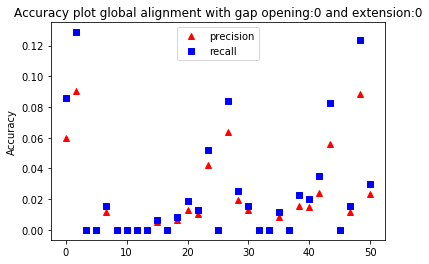

In [20]:

# evenly sampled time at 200ms intervals
t = np.linspace(0., 50, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

In [19]:
print(sum(precision_lst)/len(precision_lst))

print(sum(recall_lst)/len(recall_lst))

0.01863527383972702
0.025645024484062674


For global alignment with gap opening penalty: 0, gap extension penalty: 0. Among over 30 cases, majority of the alignment did not capture, the average precision is 1.86% and recall accuracy is about 2.56%

In [21]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=0
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.01863527383972702
0.025645024484062674


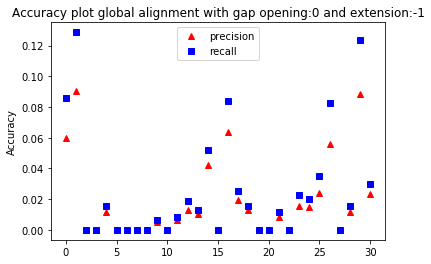

In [22]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

For global alignment with gap opening penalty: 0, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 1.86% and recall accuracy is about 2.56%

In [23]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=-5
gap_ext=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.017603698334173884
0.021476026363095608


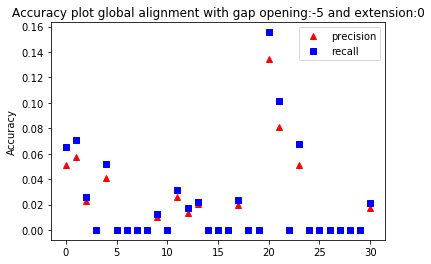

In [24]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

For global alignment with gap opening penalty: -5, gap extension penalty: 0. Among over 30 cases, majority of the alignment did not capture, the average precision is 1.76% and recall accuracy is about 2.15%

In [25]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=-5
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.02561243037774232
0.02734390909444388


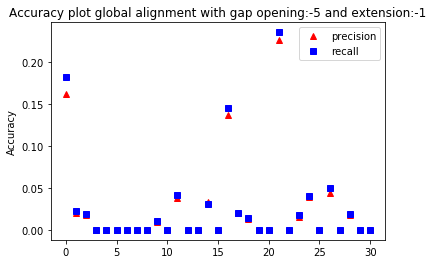

In [26]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

For global alignment with gap opening penalty: -5, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 2.56% and recall accuracy is about 2.73%

In [27]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=-10
gap_ext=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.007435884145668469
0.007741761417674725


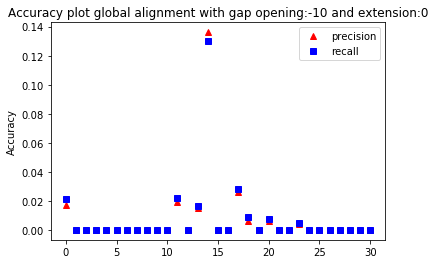

In [28]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

For global alignment with gap opening penalty: -10, gap extension penalty: 0. Among over 30 cases, majority of the alignment did not capture, the average precision is 0.74% and recall accuracy is about 0.77%

In [29]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=-10
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.014759078349125543
0.014934454149495187


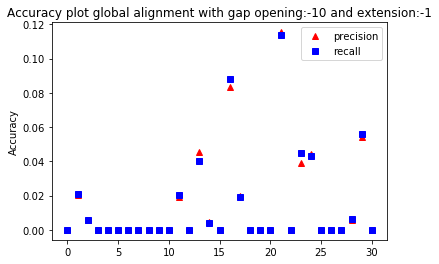

In [30]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'g_o{gap}e{gap_ext}'))

For global alignment with gap opening penalty: -10, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 1.48% and recall accuracy is about 1.49%

In [31]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=0
gap_ext=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.03606882346563248
0.049947518092517705


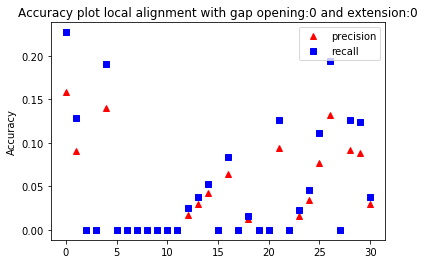

In [32]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: 0, gap extension penalty: 0. Among over 30 cases, majority of the alignment did not capture, the average precision is 3.61% and recall accuracy is about 4.99%

In [33]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=0
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.03211254485310649
0.04474962371440317


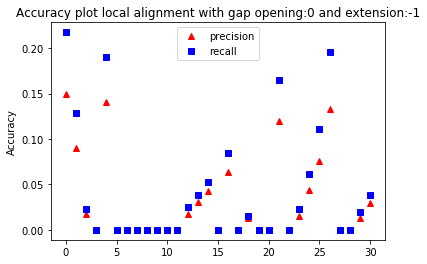

In [34]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: 0, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 3.21% and recall accuracy is about 4.47%

In [35]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=-5
gap_ext=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.039853043218781
0.04931841112103464


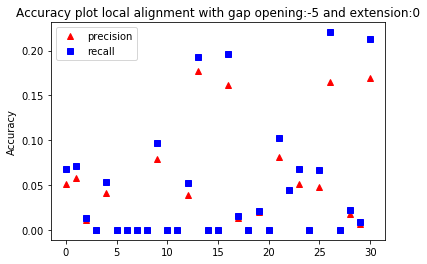

In [36]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: -5, gap extension penalty: 0. Among over 30 cases, majority of the alignment did not capture, the average precision is 3.99% and recall accuracy is about 4.93%

In [37]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=-5
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.05005167144997236
0.05688956704620027


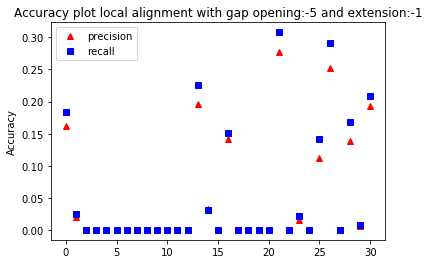

In [38]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: -5, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 5.00% and recall accuracy is about 5.69%

In [39]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=-10
gap_ext=0

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.043749307201647394
0.05038713425233078


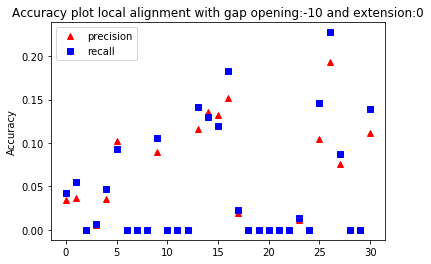

In [40]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: -10, gap extension penalty: -0. Among over 30 cases, majority of the alignment did not capture, the average precision is 4.37% and recall accuracy is about 5.04%

In [41]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=-10
gap_ext=-1

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.06745870665879376
0.08134470198585798


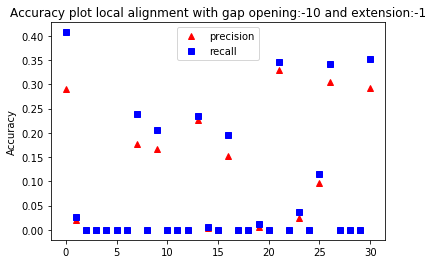

In [42]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.savefig(os.path.join("/home/chingyuenliu/TTIC31160_bioinfo/hw1",f'loc_o{gap}e{gap_ext}'))

For local alignment with gap opening penalty: -10, gap extension penalty: -1. Among over 30 cases, majority of the alignment did not capture, the average precision is 6.75% and recall accuracy is about 8.13%

In [48]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=True
gap=-5
gap_ext=-1
match=1
mmatch=-1
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,match =match,mmatch=mmatch,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)

0.015911298271815807
0.16129032258064516


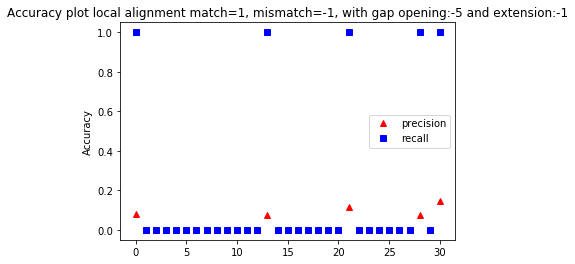

In [50]:
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot local alignment match={match}, mismatch={mmatch}, with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.show()

0.033695722750580887
0.03130437282262533


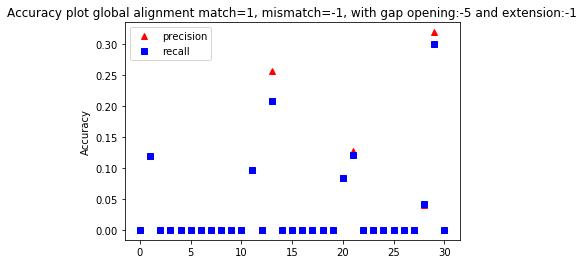

In [51]:
directory = os.fsencode(directory_in_str)
counter = 0
precision_lst =[]
recall_lst=[]

local=False
gap=-5
gap_ext=-1
match=1
mmatch=-1
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
    seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
    mtx=mkmtx(seq0,seq1,local=local,match =match,mmatch=mmatch,gap=gap,gap_ext=gap_ext)
    seq0_al,seq1_al=back_tracing(seq0,seq1,mtx,local=local)
    pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
    precision_lst.append(pre)
    recall_lst.append(rec)
print(sum(precision_lst)/len(precision_lst))
print(sum(recall_lst)/len(recall_lst))


# evenly sampled time at 200ms intervals
t = np.linspace(0., 30, len(precision_lst))

# red dashes, blue squares and green triangles
plt.plot(t, precision_lst, 'r^',label='precision')
plt.plot(t, recall_lst, 'bs',label='recall')
plt.ylabel('Accuracy')
plt.title(f'Accuracy plot global alignment match={match}, mismatch={mmatch}, with gap opening:{gap} and extension:{gap_ext}')
plt.legend()
plt.show()

In [52]:
filename="file_1"
local=False
gap=-10
gap_ext=-1

seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
seq0_al_10,seq1_al_10=back_tracing(seq0,seq1,mtx,local=local)
pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
print(pre)
print(rec)

0.0
0.0


In [53]:
seq0_al_10

'ggcaaaggagatc-ctaaaaagcc-gaga-ggcaaaatgtcctcatatgcattctttgtgcaaacttgccgggaggagc---acaag-aa--gaag---caccc------g-g--a--tgcttctg--tc--aacttctcagagttctccaa-gaagtgctcagagaggtggaagaccatgtctgctaaaga-----aaaggggaaatttgaagatatggcaaaggctgacaaggctcgttatgaaagagaaatgaaaacc-tacatcccccccaaag---gggag'

In [54]:
seq1_al_10

'ggcaaa-aagctcaagaaacacccggattttccaaagaaacctctcaccccttacttccgc-ttctt-catggagaagcgggccaagtacgcgaagctccacccggagatgagcaacctggacctgactaagatcctgtctaagaaatacaaggaacttc-cagagaagaagaagatgaaatatattcaggacttccagagggagaaacaggagttcgagcgaa-----acctggcccgat-tcagggag-ga--tcaccctgaccttatccagaatgccaagaag'

In [55]:
filename="file_1"
local=False
gap=-0
gap_ext=-1

seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
seq0_al_0,seq1_al_0=back_tracing(seq0,seq1,mtx,local=local)
pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
print(pre)
print(rec)

0.0
0.0


In [56]:
seq0_al_0

'ggcaaaggagatc-ct-aa-aaag---ccgagagg----ca-aaatgt----c-ctca-----ta--t--gcattctt--tgtgca-aacttgccgggaggagcacaaga-a---gaag---cacccggatgcttc-tgt--caacttctcagagtt-ctc---c-aagaagtg-c--tc-agagagg--tgg--aa-gacca-tgtctgctaa-agaa-aaggggaa-atttgaagatatggcaa---agg-ctga--ca-aggctcgttatgaaag-agaa-a--t-ga---aaacct------a--c-------at--ccc---cc----cca-aagg-g----g-ag'

In [57]:
seq1_al_0

'ggcaaa--a-a--gctcaagaaa-cacccg-ga--ttttc-caaa-g-aaacctctcaccccttacttccgc-ttcttcatg-g-agaa---g-c----gg-gc-caag-tacgcgaagctccacccgga-g----atg-agcaac--ct--g-g--ac-ctgactaag-a-t-cctgtcta-aga--aat--acaagga--act-tc--c--agagaagaa---gaaga--tgaa-atat----attcaggact--tccagagg---g--a-gaaa-cag--gagttcgagcgaaacctggcccgattcagggaggatcaccctgaccttatccagaa--tgccaagaag'

In [367]:
seq1_al_10

'ggcaaa--a-ag--ctcaagaaacacccggattttccaaagaaacctctcaccccttacttccgcttcttcatggagaagcgggccaagtacgcgaagctccacccggagatgagcaacctgga-----cctgactaagatcctgtctaagaa--atacaaggaa--cttccagagaagaagaagatgaaatatattcaggacttccag---a-gggagaa---acaggagttcgagcgaa-----acctggcccgattca----gggag--gatcaccctgaccttatc--cagaatgccaagaag'

In [58]:
filename="file_1"
local=True
gap=-10
gap_ext=-1

seq0,seq1 =load_seq(os.path.join(directory_in_str, filename))
seq0_gt,seq1_gt =load_seq(os.path.join(ground_path_dir, filename))
mtx=mkmtx(seq0,seq1,local=local,gap=gap,gap_ext=gap_ext)
seq0_l_10,seq1_l_10=back_tracing(seq0,seq1,mtx,local=local)
pre,rec=accuracy(seq0_gt,seq1_gt,seq0_al,seq1_al)
print(pre)
print(rec)

0.0
0.0


In [60]:
seq1_l_10

'ggcaaa-aagctcaagaaacacccggattttccaaagaaacctctcaccccttacttccgc-ttctt-catggagaagcgggccaagtacgcgaagctccacccggagatgagcaacctggacctgactaagatcctgtctaagaaatacaaggaacttc-cagagaagaagaagatgaaatatattcaggacttccagagggagaaacaggagttcgagcgaaacctggcccgattcagggaggatcaccctgaccttatccagaatgccaagaag---------------------------------------------------'

In [61]:
seq1_al_10

'ggcaaa-aagctcaagaaacacccggattttccaaagaaacctctcaccccttacttccgc-ttctt-catggagaagcgggccaagtacgcgaagctccacccggagatgagcaacctggacctgactaagatcctgtctaagaaatacaaggaacttc-cagagaagaagaagatgaaatatattcaggacttccagagggagaaacaggagttcgagcgaa-----acctggcccgat-tcagggag-ga--tcaccctgaccttatccagaatgccaagaag'